In [2]:
import MySQLdb as mdb

# set db connections
import ConfigParser
cp = ConfigParser.ConfigParser()
cp.read("./database.cfg")
host = cp.get("database", "host")
user = cp.get("database", "user")
password = cp.get("database", "password")
db = cp.get("database", "db")
port=int(cp.get("database", "port"))

con = mdb.connect(host=host, port=port, user=user, passwd=password, db=db)


Now let's load up some yaks. For now we're loading ~ 500,000, primarily just because I was doing this on my own machine so I thought I'd save a little space. Our total number is on the order of 2 million. Also, these 500,000 are from when the script first started running, before we were collecting historical data and were just updating the score for old yaks each time the script ran rather than storing historical values. The result of this is just that it's much simpler SQL query to get this data and so it finishes faster to do some initial exploration.

In [3]:
sql = "SELECT * FROM yaks WHERE score IS NOT NULL ORDER BY RAND() LIMIT 500000"
import pandas as pd
yak_table = pd.read_sql(sql, con=con)
print yak_table.shape


(500000, 8)


In [4]:
yak_table = yak_table[yak_table.score < 10000] # messages from Yik Yak HQ come with this ridiculous score

## Descriptive Stats

Distribution of votes.

In [4]:
yak_table["score"].describe()

count    499999.000000
mean         12.138548
std          19.058663
min          -4.000000
25%           2.000000
50%           6.000000
75%          15.000000
max         568.000000
dtype: float64

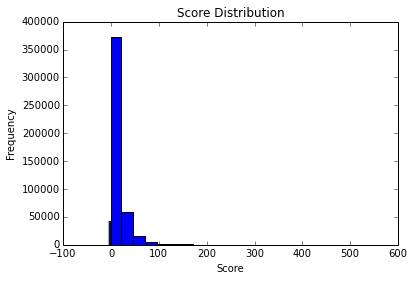

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt


#n, bins, patches = plt.hist(yak_table["score"], bins=15)
#plt.cle
#bins = sorted(bins + [0])
n, bins, patches = plt.hist(yak_table["score"], bins=sorted(range(min(yak_table["score"]), max(yak_table["score"]) + 25, 25) + [0]))
plt.title("Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

Describe number of yaks collected in each location. We have 35 schools. Mean number of yaks per school is ~ 14,285.

In [6]:
by_location = yak_table.groupby(yak_table.location_id)
by_location.size().describe()

count       35.000000
mean     14285.685714
std      10733.615404
min        627.000000
25%       4508.000000
50%      12819.000000
75%      22527.000000
max      38105.000000
dtype: float64

## Word Frequencies

First treat all yaks as a giant corpus. NLTK assumes that we have an actual corpus made up of sentences. Parsing short texts like this is a difficult thing. So to tokenize, we'll just regex anything that looks like a word. This is just to get a sense of frequently used words across all yaks. Worth looking into research on parsing tweets and if we could use some of those libraries.

In [7]:
from nltk.tokenize import RegexpTokenizer
import nltk

tokenizer = RegexpTokenizer(r'\w+')
corpus = ' '.join(yak_table.message)
tokens = tokenizer.tokenize(corpus)
text = [t.lower() for t in nltk.Text(tokens)]

fdist = nltk.FreqDist(text)
for frequencies in fdist.items()[:20]:
    print "%s: %s\n" % (frequencies[0], frequencies[1])


i: 275376

the: 222192

to: 197511

a: 175191

you: 135493

and: 122836

my: 105638

is: 92175

in: 91274

it: 83169

of: 80340

t: 71765

s: 69781

that: 66522

on: 66259

for: 64503

me: 59463

just: 51515

m: 48138

with: 45741



Just removing stop words that come with NLTK...

In [8]:
from nltk.corpus import stopwords
filtered_words = [w for w in text if not w in stopwords.words('english')]

print "After we remove words from this list: %s" % stopwords.words('english')

fdist = nltk.FreqDist(filtered_words)
for frequencies in fdist.items()[:20]:
    print "%s: %s\n" % (frequencies[0], frequencies[1])

After we remove words from this list: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can'

Next steps:
1. Probably do this per school. I imagine each school will talk about different things more frequently. Maybe use something like tf-idf where we treat each campus as a yak corpus? What words show up a lot in each school but not at all in other schools?
2. Figure out why "m" is at the top of this list.

## Modeling

In retrospect, I don't know if this is really all that useful of a thing to do. We basically just bin yaks and train some models based on bag of words models. This is more the type of thing that is useful if we wanted to predict what yaks got downvoted and highly upvoted. Which is maybe a cool thing but not that descriptive. I think I was hoping that if we looked at highly weighted words by the model, there would be some interesting insight about words that are very predictive. That doesn't seem to be the case. But here's what happened.

First, we're going to bin data we have based on score. The purpose of this is to fit some classification models that predict which bin a yak would fall into. This is maybe tricky based on score distribution. Interesting categories to me are anything that is negative, things that are close to 0, and things that are highly upvoted. There's probably a better scientific way to determine the treshold of what highly upvoted means here. For now, I'm choosing an arbitrary value (20).

In [9]:
negative_yaks =  yak_table[yak_table.score < 0].message
neutral_yaks = yak_table[(yak_table.score >= 0) & (yak_table.score <= 20)].message
positive_yaks = yak_table[yak_table.score > 20].message

print "%s negative \n%s neutral \n%s positive" % (len(negative_yaks), len(neutral_yaks), len(positive_yaks))


41805 negative 
372539 neutral 
85655 positive


Now we'll create a matrix. Y = -1, 0, or +1 for each category. X is a binary bag of words vector (words are represented by 0 or 1 by whether or not they appear in a yak.)

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

count_vect = CountVectorizer(binary=True, ngram_range=(1,2))
X = count_vect.fit_transform(np.concatenate((negative_yaks, neutral_yaks, positive_yaks)))
y = np.array([-1.] * len(negative_yaks) + [0.] * len(neutral_yaks) + [1.] * len(positive_yaks))


Train a classifier. Cross validation score is just out of curiosity. (Commented out for now because this takes a really long time. IIRC before I tried to rerun everything, this did achieve decent accuracy, but F1 would be a better metric given the imbalanced nature of class labels.)

In [26]:
#from sklearn.linear_model import LogisticRegression
#from sklearn import cross_validation
#clf = LogisticRegression()
#print 'Average F1=%.3f' % np.average(cross_validation.cross_val_score(clf, X, y, cv=5, scoring='f1'))

Now we fit data. For each class, print top features of each. 0=negative, 1=neutral, 2=positive

In [27]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='l2')
clf.fit(X, y)  # fit on all data

feature_names = np.asarray(count_vect.get_feature_names())

for i in range(3):
    top25 = np.argsort(clf.coef_[i])[-25:]
    print "%s: %s\n" % (i, ",".join(feature_names[top25]))

0: jay,ted,mike,than twice,george,finelli,sam,faith,niggas,nigga,carry,middle,ryan,matt,douglass,tiny,michael,byu students,teddy,alex,clark,page,molly,sunny,bit

1: way into,yes on,when hungry,she asks,you lock,first girl,that calc,seizure,probably would,number that,time what,comes the,poly kids,fuck tonight,guy what,push you,take in,some cold,every word,louisville,one not,but fucking,union south,until tomorrow,with beards

2: psafe,gustin,hug bottle,leebron,bartlett,babylon,union,mansueto,hatch,peirce,fuck bc,wabash,block plan,mines,depauw,guys me,goal relationship,sosc,rpi,northwestern,prospies,prospie,angie,marx,uchicago



The machine learning module we're using, `scikit-learn` doesn't do real multinomial logistic regression. It uses a one vs. all hack to predict multiple classes, which is generally fine for prediction purposes but doesn't give us real regression coefficients. We could do the same things we did above but just focus on negative vs. highly upvoted categories...

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

X = count_vect.fit_transform(np.concatenate((negative_yaks, positive_yaks)))
y = np.array([0] * len(negative_yaks) + [1.] * len(positive_yaks))


In [15]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='l2')
clf.fit(X, y)  # fit on all data

feature_names = np.asarray(count_vect.get_feature_names())

top_indices = clf.coef_[0].argsort()[::-1] 
vocab_r = dict((idx, word) for word, idx in count_vect.vocabulary_.iteritems())
print 'Positive words:\n', '\n'.join(['%s=%.3f' % (vocab_r[idx], clf.coef_[0][idx]) for idx in top_indices[:20]])
top_indices = clf.coef_[0].argsort() # sort in increasing order
print '\n\Negative words:\n', '\n'.join(['%s=%.3f' % (vocab_r[idx], clf.coef_[0][idx]) for idx in top_indices[:20]])

Positive words:
ucsb=2.131
wabash=2.013
59=1.928
depauw=1.835
guys me=1.792
union=1.769
clemson=1.763
rpi=1.751
duke=1.750
bigelow=1.721
cuddling=1.699
thanksgiving=1.680
fondren=1.660
hatch=1.623
iv=1.616
angie=1.600
november=1.599
mouse duh=1.596
responsibilities=1.586
couples=1.584

\Negative words:
bit=-3.328
page=-2.977
sunny=-2.942
jack=-2.682
middle=-2.671
nigga=-2.508
kik=-2.482
byu students=-2.385
alex=-2.262
matt=-2.143
carry=-2.134
michael=-2.122
chase=-2.080
john=-2.025
molly=-2.013
suggestions=-2.012
taylor=-1.963
faith=-1.942
tiny=-1.934
tom=-1.931


...but that feels weird because we're leaving out a ton of data and creating a not all that helpful model since those words could appear in neutral yaks which would effect their score. Out of curiousity, let's do this all again and just have the dependent variable be whether or not a yak has a negative score or not.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

X = count_vect.fit_transform(np.concatenate((negative_yaks, neutral_yaks, positive_yaks)))
y = np.array([0] * len(negative_yaks) + [1.] * (len(neutral_yaks) + len(positive_yaks)))


In [17]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='l2')
clf.fit(X, y)  # fit on all data

feature_names = np.asarray(count_vect.get_feature_names())

top_indices = clf.coef_[0].argsort()[::-1] 
vocab_r = dict((idx, word) for word, idx in count_vect.vocabulary_.iteritems())
print 'Positive words:\n', '\n'.join(['%s=%.3f' % (vocab_r[idx], clf.coef_[0][idx]) for idx in top_indices[:20]])
top_indices = clf.coef_[0].argsort() # sort in increasing order
print '\n\Negative words:\n', '\n'.join(['%s=%.3f' % (vocab_r[idx], clf.coef_[0][idx]) for idx in top_indices[:20]])

Positive words:
bigelow=1.569
co what=1.522
loud ass=1.482
mac cheese=1.459
noles=1.431
louisville=1.369
and listen=1.348
iv=1.324
see yak=1.300
zta=1.288
mouse duh=1.285
aleks=1.271
help what=1.253
tallahassee=1.242
dinosaurs=1.235
hey you=1.224
stop trying=1.223
not interested=1.222
dick pic=1.214
that point=1.213

\Negative words:
bit=-2.746
sunny=-2.565
molly=-2.532
page=-2.406
clark=-2.255
alex=-2.224
teddy=-2.144
byu students=-2.140
michael=-2.115
tiny=-2.082
douglass=-2.037
matt=-2.008
ryan=-2.003
middle=-1.996
carry=-1.979
nigga=-1.969
niggas=-1.960
faith=-1.934
sam=-1.922
finelli=-1.913


## LIWC

This took a little while to get going, but now I think we'll be able to do a lot more experiments with it. Essentially, the scale of our data makes working with LIWC software pretty difficult. We're just using a Python script to read in the dictionary and do some things with that. **NOTE:** LIWC scores I think are typically defined as a fraction. Positive emotion in a document would be the total number of positive emotion words divided by all the words in the document. Our "documents" are short enough that I'm not sure this makes sense, so the numbers you see below are just the **total count** of each type of word. So when I say average positive emotion for all yaks is .55, that doesn't mean on average each yak has over half of its words as positive emotion words. It means a lot of yaks don't contain any, dragging the average down to less than one per yak. We could do the typical LIWC approach of fraction of total document if it made sense for a particular experiment.

As I mentioned, getting up to speed with working with LIWC took some time. For some initial work I just looked at positive/negative emotion in each yak. I spit out the average of these, and then plot each with the score of the yak. These were just some initial ideas to work with the LIWC dictionary, but I think now that it's working it'll be easier to start thinking about much more targeted questions.

In [56]:
import liwc

yak_liwc = [] 

for yak in yak_table.message:
    liwc_counts = liwc.countcat(yak, ret='dict')
    yak_liwc.append(liwc_counts)
    

In [57]:
yak_table["liwc"] = pd.Series(yak_liwc)

In [20]:
print "Average positive emotion per yak: %.2f (SD: %.2f)" % (np.mean([e["pos"] for e in emotions]), np.std([e["pos"] for e in emotions]))
print "Average negative emotion per yak: %.2f (SD: %.2f)" % (np.mean([e["neg"] for e in emotions]), np.std([e["neg"] for e in emotions]))

Average positive emotion per yak: 0.54 (SD: 0.82)
Average negative emotion per yak: 0.46 (SD: 0.74)


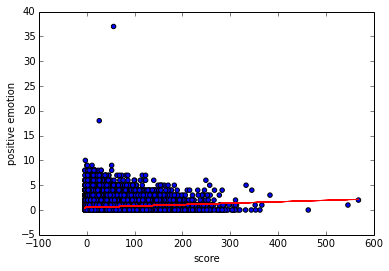

In [21]:
x = yak_table.score
y = [e["pos"] for e in emotions]
p = np.polyfit(x, y, 1)
plt.scatter(x, y)
plt.plot(x,np.polyval(p,x),'r-')
plt.xlabel("score")
plt.ylabel("positive emotion")
plt.show()

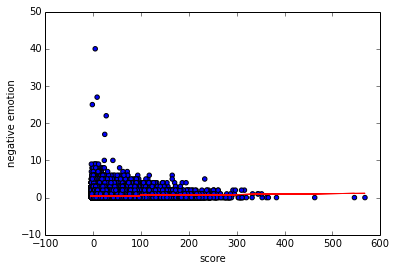

In [23]:
x = yak_table.score
y = [e["neg"] for e in emotions]
p = np.polyfit(x, y, 1)
plt.scatter(x, y)
plt.plot(x,np.polyval(p,x),'r-')
plt.xlabel("score")
plt.ylabel("negative emotion")
plt.show()

## Comparing Groups

Here we bin yaks based on score. In this case, we have three categories again. One is anything with a `negative` vote. Then we look 2 standard deviations above the mean score. Anything with a score equal to or above that is `positive`. Everything else is `ordinary`.

In [8]:
mean_score = np.mean(yak_table.score)
sd_score = np.std(yak_table.score)
print "Mean score: %.3f (SD: %.3f)" % (mean_score, sd_score)

Mean score: 12.140 (SD: 19.083)


In [9]:
positive_threshold = mean_score + 2*sd_score

negative_yaks = yak_table[yak_table.score < 0]
ordinary_yaks = yak_table[(yak_table.score >= 0) & (yak_table.score < positive_threshold)]
positive_yaks = yak_table[yak_table.score >= positive_threshold]

print "%s negative \n%s ordinary \n%s positive" % (len(negative_yaks), len(ordinary_yaks), len(positive_yaks))

41872 negative 
436752 ordinary 
21375 positive


Below, we look at differences in different categories for each of these categories. First, we just plot number of words. For each of the LIWC categories, we show proportion of yaks in each category that contain any LIWC words for that category.

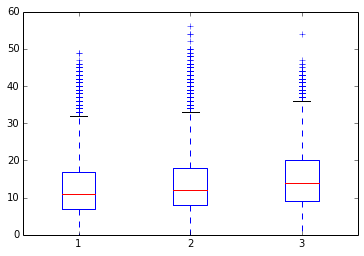

In [148]:
%matplotlib inline
import pylab as plt
negative = [l["n"] for l in negative_yaks.liwc]
ordinary = [l["n"] for l in ordinary_yaks.liwc if type(l) is not float]
positive = [l["n"] for l in positive_yaks.liwc]
plt.boxplot([negative, ordinary, positive])
plt.show()

First person personal pronouns:

In [142]:
from __future__ import division
    
negative = [l["i"] for l in negative_yaks.liwc]
ordinary = [l["i"] for l in ordinary_yaks.liwc if type(l) is not float]
positive = [l["i"] for l in positive_yaks.liwc]

nn_negative, nn_ordinary, nn_positive = (len([n for n in negative if n != 0]), len([o for o in ordinary if o != 0]), len([p for p in positive if p != 0]))

print "Proportion of yaks for each category:"
print "Negative: %s \nOrdinary: %s \nPositive: %s" % (nn_negative/len(negative), nn_ordinary/len(ordinary), nn_positive/len(positive))

Proportion of yaks for each category:
Negative: 0.446475133364 
Ordinary: 0.487586825826 
Positive: 0.491145273585


Negative emotion:

In [143]:
from __future__ import division
    
negative = [l["negemo"] for l in negative_yaks.liwc]
ordinary = [l["negemo"] for l in ordinary_yaks.liwc if type(l) is not float]
positive = [l["negemo"] for l in positive_yaks.liwc]

nn_negative, nn_ordinary, nn_positive = (len([n for n in negative if n != 0]), len([o for o in ordinary if o != 0]), len([p for p in positive if p != 0]))

print "Proportion of yaks for each category:"
print "Negative: %s \nOrdinary: %s \nPositive: %s" % (nn_negative/len(negative), nn_ordinary/len(ordinary), nn_positive/len(positive))

Proportion of yaks for each category:
Negative: 0.324354711384 
Ordinary: 0.347603217993 
Positive: 0.361011167702


Any personal pronouns:

In [144]:
from __future__ import division
    
negative = [l["ppron"] for l in negative_yaks.liwc]
ordinary = [l["ppron"] for l in ordinary_yaks.liwc if type(l) is not float]
positive = [l["ppron"] for l in positive_yaks.liwc]

nn_negative, nn_ordinary, nn_positive = (len([n for n in negative if n != 0]), len([o for o in ordinary if o != 0]), len([p for p in positive if p != 0]))

print "Proportion of yaks for each category:"
print "Negative: %s \nOrdinary: %s \nPositive: %s" % (nn_negative/len(negative), nn_ordinary/len(ordinary), nn_positive/len(positive))

Proportion of yaks for each category:
Negative: 0.629308901275 
Ordinary: 0.685856490703 
Positive: 0.731227512733


Swear words:

In [127]:
from __future__ import division
    
negative = [l["swear"] for l in negative_yaks.liwc]
ordinary = [l["swear"] for l in ordinary_yaks.liwc if type(l) is not float]
positive = [l["swear"] for l in positive_yaks.liwc]

nn_negative, nn_ordinary, nn_positive = (len([n for n in negative if n != 0]), len([o for o in ordinary if o != 0]), len([p for p in positive if p != 0]))

print "Proportion of yaks for each category:"
print "Negative: %s \nOrdinary: %s \nPositive: %s" % (nn_negative/len(negative), nn_ordinary/len(ordinary), nn_positive/len(positive))

Proportion of yaks for each category:
Negative: 0.167144838139 
Ordinary: 0.16524723325 
Positive: 0.15810646459


Social processes:

In [145]:
from __future__ import division
    
negative = [l["social"] for l in negative_yaks.liwc]
ordinary = [l["social"] for l in ordinary_yaks.liwc if type(l) is not float]
positive = [l["social"] for l in positive_yaks.liwc]

nn_negative, nn_ordinary, nn_positive = (len([n for n in negative if n != 0]), len([o for o in ordinary if o != 0]), len([p for p in positive if p != 0]))

print "Proportion of yaks for each category:"
print "Negative: %s \nOrdinary: %s \nPositive: %s" % (nn_negative/len(negative), nn_ordinary/len(ordinary), nn_positive/len(positive))

Proportion of yaks for each category:
Negative: 0.609429945219 
Ordinary: 0.629566798079 
Positive: 0.677585159572


Affect:

In [146]:
from __future__ import division
    
negative = [l["affect"] for l in negative_yaks.liwc]
ordinary = [l["affect"] for l in ordinary_yaks.liwc if type(l) is not float]
positive = [l["affect"] for l in positive_yaks.liwc]

nn_negative, nn_ordinary, nn_positive = (len([n for n in negative if n != 0]), len([o for o in ordinary if o != 0]), len([p for p in positive if p != 0]))

print "Proportion of yaks for each category:"
print "Negative: %s \nOrdinary: %s \nPositive: %s" % (nn_negative/len(negative), nn_ordinary/len(ordinary), nn_positive/len(positive))

Proportion of yaks for each category:
Negative: 0.566873190919 
Ordinary: 0.60225873066 
Positive: 0.6288491192


Cognitive Processes:

In [147]:
from __future__ import division
    
negative = [l["cogmech"] for l in negative_yaks.liwc]
ordinary = [l["cogmech"] for l in ordinary_yaks.liwc if type(l) is not float]
positive = [l["cogmech"] for l in positive_yaks.liwc]

nn_negative, nn_ordinary, nn_positive = (len([n for n in negative if n != 0]), len([o for o in ordinary if o != 0]), len([p for p in positive if p != 0]))

print "Proportion of yaks for each category:"
print "Negative: %s \nOrdinary: %s \nPositive: %s" % (nn_negative/len(negative), nn_ordinary/len(ordinary), nn_positive/len(positive))

Proportion of yaks for each category:
Negative: 0.720426763629 
Ordinary: 0.766155212755 
Positive: 0.807298724359


## Regression

Some basic models using some LIWC data. First dependent variable is log(score+5).  Independent variables are dicohtomous variables of whether or not a yak contains any LIWC words in the following categories: cognitice process, affect, personal pronoun, swear words. Also included is the number of words in the yak.

In [144]:
Y = np.log(yak_table.score + 5)

# binarize liwc scores. 1 if the category is present at all, else 0
cognitive = pd.Series([1 if y else 0 for y in [l["cogmech"] for l in yak_table.liwc if type(l) is not float]])
affect = pd.Series([1 if y else 0 for y in [l["affect"] for l in yak_table.liwc if type(l) is not float]])
personal_pronouns = pd.Series([1 if y else 0 for y in [l["ppron"] for l in yak_table.liwc if type(l) is not float]])
swear_words = pd.Series([1 if y else 0 for y in [l["swear"] for l in yak_table.liwc if type(l) is not float]])

yak_length = pd.Series([l["n"] for l in yak_table.liwc if type(l) is not float])

regression_df = pd.DataFrame({"score": Y,
                              "cognitive_process": cognitive,
                              "affect": affect,
                              "personal_pronouns": personal_pronouns,
                              "swear_words": swear_words,
                              "yak_length": yak_length})
regression_df.head()



,affect,cognitive_process,personal_pronouns,score,swear_words,yak_length
0,1,1,0,7,0,8
1,0,1,0,6,0,6
2,0,1,1,6,0,10
3,0,1,1,33,0,17
4,1,1,1,21,0,12


In [141]:
import statsmodels.formula.api as st

model = st.ols(formula = "score ~ C(affect) + C(cognitive_process) + C(personal_pronouns) + C(swear_words) + yak_length",
               data=regression_df)

model_fit = model.fit()

print model_fit.summary()

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1475.
Date:                Mon, 23 Feb 2015   Prob (F-statistic):               0.00
Time:                        15:41:45   Log-Likelihood:            -6.1499e+05
No. Observations:              499997   AIC:                         1.230e+06
Df Residuals:                  499991   BIC:                         1.230e+06
Df Model:                           5                                         
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                       2.2729      0.003    782.734      0.000         2.267     2.279
C

In [142]:
print model_fit.params

Intercept                      2.272908
C(affect)[T.1.0]               0.021227
C(cognitive_process)[T.1.0]    0.032309
C(personal_pronouns)[T.1.0]    0.048330
C(swear_words)[T.1.0]         -0.038102
yak_length                     0.009838
dtype: float64


Multinomial logit model where the dependent variable is just the categories defined above (negative, ordinary, positive.) Same independent variables.

In [145]:
import statsmodels.api as st

regression_df.score[regression_df.score >= positive_threshold] = 1
regression_df.score[(regression_df.score >= 0) & (regression_df.score < positive_threshold)] = 1
regression_df.score[regression_df.score < 0] = -1

model = st.MNLogit.from_formula("score ~ C(affect) + C(cognitive_process) + C(personal_pronouns) + C(swear_words) + yak_length",
               data=regression_df)

model_fit = model.fit()

print model_fit.summary()

Optimization terminated successfully.
         Current function value: 0.286052
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                  score   No. Observations:               499997
Model:                        MNLogit   Df Residuals:                   499991
Method:                           MLE   Df Model:                            5
Date:                Mon, 23 Feb 2015   Pseudo R-squ.:                0.005385
Time:                        16:03:19   Log-Likelihood:            -1.4303e+05
converged:                       True   LL-Null:                   -1.4380e+05
                                        LLR p-value:                     0.000
                    score=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                       1.9844      0.012    169.594      0.000   

## Comparing Campuses

### TD-IDF

First, we're just going to treat each campus as a corpus. Then we compute tf-idf for each word, and list the highly ranked words for each campus. TF-IDF should give us words that are important (well, frequent) within a corpus (campus), but that don't appear across all campuses. So, my intuition is that it will give us words that are specific and important to each school, which could be interesting. Note we ignore words that occur with great frequency within a document (TfidfVectorizer `max_df` set to 0.7). This is sort of a per document stopword removal that let's us see more interesting words (for example, the word "like" might appear a lot, but it's not as interesting as seeing words like "Evanston" for Northwestern, which might be technically less frequent but more semantically interesting).

In [10]:
grouped_by_campus = yak_table.groupby(yak_table.location_id).message

corpuses = [] # we'll store them here

for group, values in grouped_by_campus:
    corpuses.append(" ".join(values))
    

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

vectorizer = TfidfVectorizer(min_df=1, stop_words=stopwords.words("english"), ngram_range=(1,2), max_df=0.7)
tfidf_matrix = vectorizer.fit_transform(corpuses).todense()


In [12]:
feature_names = np.asarray(vectorizer.get_feature_names())

# let's also get location names out of the database to make
# this more interpretable.
sql = "SELECT * FROM locations"
location_table = pd.read_sql(sql, con=con)
locations = location_table.name.tolist()


In [13]:
all_top_words = []

# now print top words
for i in range(len(tfidf_matrix)):
    index = np.argsort(tfidf_matrix[i])
    top10 = index.tolist()[0][-10:]
    top_words = feature_names[top10]
    all_top_words.extend(top_words)
    print "%s: %s\n" % (locations[i], ",".join(top_words))

syracuse: euclid,comstock,duke,general body,esf,sadler,lawrinson,kent,cuse,syracuse

brown: city burger,renny,prov,blum,gaebe,xavier,mcnulty,providence,snowden,jwu

nyu: silberberg,palladium,stevens,pace,bmcc,baruch,nyc,bobst,halpin,nyu

rutgers: ep,sig ep,orgo,expos,ru,lx,college ave,brower,livi,rutgers

kenyon: mcbride,cove,nite,asian beetles,kac,kenyon football,daltronix,nite bites,peirce,kenyon

colorado: loomis,tutt,block plan,block break,udall,mathias,bemis,worner,rastall,cc

mines: elm,3rb,deutsch,deutsch deutsch,ctlm,cu,epics,slate,seger,mines

trinity: tolteca,belgrove,dublin bus,ucd,tesco,irish,blackhall,centra,ireland,dublin

alabama: tuscaloosa,paty,ua,roll tide,tide,fall break,lofts,lakeside,auburn,lsu

haverford: roman candle,haverford college,lm,bryn,bryn mawr,mawr,weird weird,gal,haverford,gal gal

ucsb: bigelow,birnir,poly,cal,dlg,dp,cal poly,towners,iv,ucsb

lafeyette: finelli,ruef,aphi,skillman,flags,laf,lehigh,aphihorsestuff,lafayette,spring concert

rensselaer: dcc

So, we see a lot of the things I guess we would expect to see. School and city names. Rivals. And maybe some other interesting things. "Honor code," for example, is a top BYU feature. Let's look at how yaks that mention these are voted on. We'll use the same negative, ordinary, and positive groups as before, and just go through and count how many contain any of these words. (What we'd really want to do is check the location of each yak and then check it against the appropriate list, but this can give us a general idea.)

In [127]:
from __future__ import division

def intersect(a, b):
     return list(set(a) & set(b))

negative = [yak for yak in negative_yaks.message if intersect(yak.split(), all_top_words)]
print "Proportion of negative yaks that contain at least one phrase: % .3f" % (len(negative)/len(negative_yaks))

                                                                      
ordinary = [yak for yak in ordinary_yaks.message if intersect(yak.split(), all_top_words)]
print "Proportion of ordinary yaks that contain at least one phrase: % .3f" % (len(ordinary)/len(ordinary_yaks))
                                                                      
positive = [yak for yak in positive_yaks.message if intersect(yak.split(), all_top_words)]
print "Proportion of positive yaks that contain at least one phrase: % .3f" % (len(positive)/len(positive_yaks))


Proportion of negative yaks that contain at least one phrase:  0.023
Proportion of ordinary yaks that contain at least one phrase:  0.020
Proportion of positive yaks that contain at least one phrase:  0.025


Let's check out a few examples.

In [130]:
print "Negative examples:"
print "\n".join(negative[:3])
print "\n\n"

print "Ordinary examples:"
print "\n".join(ordinary[:3])
print "\n\n"

print "Positive examples:"
print "\n".join(positive[:3])
print "\n\n"

Negative examples:
Boutta faint in bobst 
Someone from sig ep speak up. Did someone die?
All-girls at brick Street *fighting the inner urge to become a stripper*



Ordinary examples:
What channel can i watch the cuse football game on?
Whoever the dab guy is on uw snaps hmu 
From Cortland for the night.. Let's go ithaca 



Positive examples:
I'm kinda homesick... Not because I actually miss home, but because I don't have to go to school of mines at home. 
White girls please don't stop having sex with me because of the chalk 
Friday is college night, Halloween, and baker 13. If I'm still alive saturday morning that means I did something wrong 





I guess my thinking here was that maybe yaks that mentioned these things would be upvoted more, and that might say something about the importance of location/audience. We're also working on manually compiling short lists of possibly relevant words for each campus, just things like the city name, mascot, etc. But this method gives us another programmatic way to identify such terms.

### Document Similarity

Alright, my inability to think about matrix math is keeping me from really doing this currently, but here was the idea:

For each campus, treat each individual yak as a document. Compute cosine similarity for all pairs of yaks. Then get some sort of average for those, so that for each campus I'd have some sort of overall document similarity score. The last bit is what I'm unsure of. What I end up with below is a matrix, where each row represents a yak, and each column represents the cosine similarity of that yak and another. I'm calling `mean` on that matrix, which I think just flattens the matrix and computes a mean, but I don't think that is right...

This would probably be messy, and maybe not make that much sense given a bunch of small documents (yaks). Whereas before I was treating all yaks from a given campus as a document, this time I'll be treating each yak as a document. Then, for each campus, I'll compute the average cosine similarity of all yaks. This is a way to measure document similarity used a lot in information retrieval. I think what I'd maybe like to do is something more similar to Adamic and Glance's political blogs paper, where they're not doing cosine similarity of entire documents but rather just features of those documents (URL's or phrases). But I'm not sure what the features we'd want to compare are.

My idea in doing this is something along the lines of, I imagine yaks within a location share lexical similarity, because of the types of words we identified above. I guess it probably makes sense that all yaks from Northwestern are more similar than comparing yaks from Northwestern and Penn State. I don't really know if trying to quantify that means anything or gives us anything. It seemed like something to do after thinking about TF-IDF, since we usually use those vectors in thinking about document similarity. This is all stemming from an intuition that location matters on Yik Yak, and that people within a location all adopt some of the same norms. This is something I'll keep thinking about.

In [134]:
# note, we'll use the same TfidfVectorizer as in the last section

for group, yaks in grouped_by_campus:
    tfidf = vectorizer.fit_transform(yaks)
    similarity_matrix = (tfidf * tfidf.T).A
    print similarity_matrix.mean()
    

0.0018918303673
0.00213104528961
0.00185340518678
0.00187596649421
0.00317351057312
0.00241111210601
0.00228728629985
0.00445205857963
0.0018353055177
0.00301271432193
0.00188125847556
0.00250789820611
0.00235752083691
0.0018464486298
0.00214642621651
0.00214962291295
0.00189835584697
0.00185517757663
0.0020501411532
0.00226024843669
0.00185466256195
0.00267780945792
0.00199630434128
0.00198547665976
0.00207531572034
0.00247899238759
0.00233105248217
0.00218382274944
0.00194983676549
0.00213993572246
0.00183217795484
0.00189629290914
0.00196584412655
0.00187158913694
0.00268810627935


In [104]:
only_northwestern = pd.DataFrame(yak_table.query("location_id == 26").copy())

scores = pd.Series([score for score in only_northwestern["score"]])
#Y = np.log(scores + 5)
Y = scores

def intersect(a, b):
     return list(set(a) & set(b))

# binarize liwc scores. 1 if the category is present at all, else 0
cognitive = pd.Series([1 if y else 0 for y in [l["cogmech"] for l in only_northwestern.liwc]])
affect = pd.Series([1 if y else 0 for y in [l["affect"] for l in only_northwestern.liwc]])
personal_pronouns = pd.Series([1 if y else 0 for y in [l["ppron"] for l in only_northwestern.liwc]])
swear_words = pd.Series([1 if y else 0 for y in [l["swear"] for l in only_northwestern.liwc]])

# does it contain one of our campus specific top words?
contains_top_word = pd.Series([1 if y else 0 for y in [intersect(yak.split(), all_top_words) for yak in only_northwestern.message]])

yak_length = pd.Series([l["n"] for l in only_northwestern.liwc])

regression_df = pd.DataFrame({"score": Y,
                              "cognitive_process": cognitive,
                              "affect": affect,
                              "personal_pronouns": personal_pronouns,
                              "swear_words": swear_words,
                              "contains_top_word": contains_top_word,
                              "yak_length": yak_length})


regression_df.tail()


,affect,cognitive_process,contains_top_word,personal_pronouns,score,swear_words,yak_length
7474,1,1,0,0,12,1,10
7475,1,1,0,1,28,0,25
7476,1,1,0,1,48,1,21
7477,1,0,0,0,4,1,4
7478,0,1,0,1,4,0,13


In [105]:
import statsmodels.formula.api as st

model = st.ols(formula = "score ~ C(affect) + C(cognitive_process) + C(personal_pronouns) + C(swear_words) + C(contains_top_word) + yak_length",
               data=regression_df)

model_fit = model.fit()

print model_fit.summary()

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     37.82
Date:                Thu, 02 Apr 2015   Prob (F-statistic):           1.76e-45
Time:                        12:21:45   Log-Likelihood:                -37074.
No. Observations:                7479   AIC:                         7.416e+04
Df Residuals:                    7472   BIC:                         7.421e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept             

In [116]:
x = []
per_record = []
for record in only_northwestern.liwc:
    for c in liwc.categories.values():
        per_record.append(record[c])
    x.append(per_record)
    per_record = []

In [120]:
Y = scores

print len(Y)

7479


In [122]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=250,
                              random_state=0)

forest.fit(x, Y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 18 (0.068718)
2. feature 3 (0.033145)
3. feature 13 (0.031876)
4. feature 54 (0.031708)
5. feature 37 (0.029230)
6. feature 49 (0.025436)
7. feature 20 (0.024404)
8. feature 53 (0.024059)
9. feature 55 (0.023828)
10. feature 10 (0.023783)


In [127]:
liwc.categories.values()[10]

'time'

NameError: name 'a' is not defined